
**Classification of MNIST Dataset Using a Multi-Layer Perceptron (MLP) in PyTorch**



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import numpy as np

**List of Hyperparameters**

In [ ]:
# Hyperparameters
depth = 3  # Number of hidden layers
neurons = 512  # Number of neurons per hidden layer
activation_function = nn.ReLU()  # Activation function
dropout_rate = 0.5  # Dropout rate
batch_norm = True  # Batch normalization
learning_rate = 0.001
epochs = 20
batch_size = 64

**Dataset Loading and Preprocessing**

In [ ]:
# Data Preprocessing and Augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation
    transforms.RandomAffine(0, scale=(0.8, 1.2)),  # Random scaling
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load MNIST Dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 57.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.05MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.24MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Number of training samples: 60000
Number of testing samples: 10000


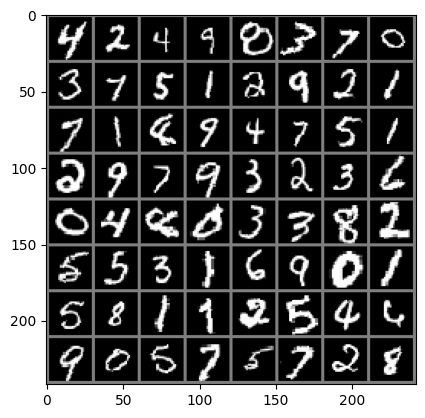

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

**Implementing a custom weight initialization function for the network**

In [ ]:
# Custom Weight Initialization
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0)

**MLP Model Design**

In [ ]:
# Define MLP Model
class MLP(nn.Module):
    def __init__(self, depth, neurons, activation_function, dropout_rate, batch_norm):
        super(MLP, self).__init__()

        layers = []
        input_size = 28 * 28  # 28x28 images flattened to a 1D vector
        for _ in range(depth):
            layers.append(nn.Linear(input_size, neurons))
            if batch_norm:
                layers.append(nn.BatchNorm1d(neurons))
            layers.append(activation_function)
            layers.append(nn.Dropout(dropout_rate))
            input_size = neurons  # Set the input size for the next layer

        layers.append(nn.Linear(neurons, 10))  # Output layer for 10 classes
        self.model = nn.Sequential(*layers)
        self.apply(initialize_weights)  # Apply custom weight initialization

    def forward(self, x):
        return self.model(x)

In [ ]:
# Define model parameters
depth = 2  # Number of hidden layers
neurons = 512  # Number of neurons per layer
activation_function = nn.LeakyReLU()  # Activation function
dropout_rate = 0.5  # Dropout rate
batch_norm = True  # Whether to include batch normalization

# Instantiate the model
model = MLP(depth=depth, neurons=neurons, activation_function=activation_function,
            dropout_rate=dropout_rate, batch_norm=batch_norm)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1  # Updated learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
def train_model(model, trainloader, criterion, optimizer, epochs):
    model.train()
    train_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in trainloader:
            inputs = inputs.view(-1, 28*28)  # Flatten images
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(trainloader))
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")
    return train_loss



**Model Evaluation**

In [ ]:
# Evaluate Model
def evaluate_model(model, testloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.view(-1, 28*28)  # Flatten images
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, cm

**Report of accuracy,Precision,F1 Score,Recall and Confusion Matrix**

Epoch 1/5, Loss: 0.8334, Accuracy: 78.97%
Epoch 2/5, Loss: 0.7791, Accuracy: 80.55%
Epoch 3/5, Loss: 0.7662, Accuracy: 80.89%
Epoch 4/5, Loss: 0.7676, Accuracy: 81.36%
Epoch 5/5, Loss: 0.7341, Accuracy: 82.43%
Final Test Accuracy: 93.05%
Precision: 0.9324
Recall: 0.9305
F1-Score: 0.9305


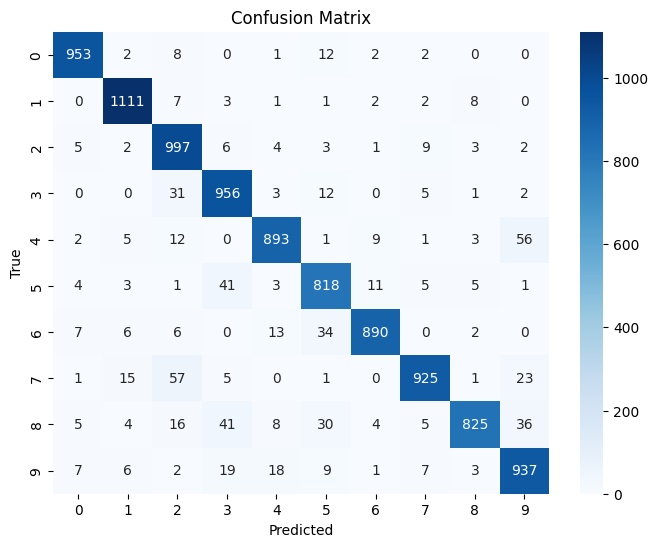

In [ ]:
# Train and evaluate the model
train_loss = train_model(model, trainloader, criterion, optimizer, epochs=5)
accuracy, precision, recall, f1, cm = evaluate_model(model, testloader)

# Report Metrics
print(f"Final Test Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Performing hyperparameter tuning to optimize the model's performance.**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np

In [ ]:
# MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth, activation_function, dropout_rate, weight_init='xavier'):
        super(MLP, self).__init__()
        self.depth = depth
        self.activation_function = activation_function
        self.dropout_rate = dropout_rate

        # Create layers based on depth
        layers = [nn.Linear(input_dim, hidden_dim)]
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, output_dim))

        self.layers = nn.ModuleList(layers)

        # Apply activation function
        if self.activation_function == 'relu':
            self.activation = nn.ReLU()
        elif self.activation_function == 'leakyrelu':
            self.activation = nn.LeakyReLU()
        elif self.activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()

        # Dropout layer
        self.dropout = nn.Dropout(p=self.dropout_rate)

        # Apply weight initialization
        self.apply(self.get_weight_init_function(weight_init))

    def get_weight_init_function(self, weight_init):
        if weight_init == 'xavier':
            return xavier_init
        return lambda m: None  # No initialization

    def forward(self, x):
        for i in range(self.depth):
            x = self.activation(self.layers[i](x))
            x = self.dropout(x)
        x = self.layers[self.depth](x)
        return x

        # Define Xavier initialization function
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


**Hyperparameter Tuning Using Grid Search**

In [ ]:
# Hyperparameter tuning function (Grid Search)
def hyperparameter_tuning(trainloader, testloader, input_dim, output_dim):
    depths = [1, 2]  # Narrowed depth options
    hidden_dims = [128, 256]  # Fewer neurons to reduce time
    activation_functions = ['relu', 'leakyrelu']  #activation options
    dropout_rates = [0.3, 0.5]  # Fewer dropout rates
    learning_rates = [0.001, 0.01]  # Reduced learning rates

    best_accuracy = 0
    best_params = {}


# Grid Search over hyperparameters
    for depth in depths:
        for hidden_dim in hidden_dims:
            for activation_function in activation_functions:
                for dropout_rate in dropout_rates:
                    for lr in learning_rates:
                        # Initialize the model
                        model = MLP(input_dim, hidden_dim, output_dim, depth, activation_function, dropout_rate, weight_init='xavier')

                        # Define loss and optimizer
                        criterion = nn.CrossEntropyLoss()
                        optimizer = optim.Adam(model.parameters(), lr=lr)

                        # Training the model with fewer epochs (e.g., 3 epochs)
                        model.train()
                        for epoch in range(3):  # Reduced number of epochs
                            running_loss = 0.0
                            for inputs, labels in trainloader:
                                inputs = inputs.view(-1, 28*28)  # Flatten images
                                optimizer.zero_grad()
                                outputs = model(inputs)
                                loss = criterion(outputs, labels)
                                loss.backward()
                                optimizer.step()
                                running_loss += loss.item()

                            # Early stopping can be added here to stop training if no improvement
                            print(f"Epoch [{epoch+1}/3], Loss: {running_loss/len(trainloader)}")

                        # Evaluate the model after training
                        accuracy, precision, recall, f1, cm = evaluate_model(model, testloader)
                        print(f"Accuracy: {accuracy:.2f}% | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}")
                        print(f"Confusion Matrix: \n{cm}")

                        # Store the best model parameters based on accuracy
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = {
                                'depth': depth,
                                'hidden_dim': hidden_dim,
                                'activation_function': activation_function,
                                'dropout_rate': dropout_rate,
                                'learning_rate': lr
                            }

    print("Best Model Hyperparameters:")
    print(best_params)
    return best_params, best_accuracy

# Call hyperparameter tuning
best_params, best_accuracy = hyperparameter_tuning(trainloader, testloader, input_dim=28*28, output_dim=10)

# Report the best accuracy
print(f"Best Accuracy achieved: {best_accuracy:.2f}%")

Epoch [1/3], Loss: 0.5875632885231901
Epoch [2/3], Loss: 0.36115178006734927
Epoch [3/3], Loss: 0.31110337069992827
Accuracy: 93.57% | Precision: 0.9365 | Recall: 0.9357 | F1-Score: 0.9356
Confusion Matrix: 
[[ 956    0    5    5    3    5    3    2    1    0]
 [   0 1117    7    5    0    1    1    1    3    0]
 [   6    4  986   11    5    1    5   10    4    0]
 [   1    0   17  948    1   21    0   12    6    4]
 [   1    1   11    1  869    3   18    2    7   69]
 [   5    2    3   34    2  826    5    6    4    5]
 [   7    4    4    1   14   29  896    0    3    0]
 [   3   10   26    4    4    0    0  966    1   14]
 [   4    5    3   39   11   29    6   12  851   14]
 [   4    6    3   18   15    6    1   11    3  942]]
Epoch [1/3], Loss: 1.0052947473487874
Epoch [2/3], Loss: 0.8132734587197619
Epoch [3/3], Loss: 0.7764399154608184
Accuracy: 85.02% | Precision: 0.8572 | Recall: 0.8502 | F1-Score: 0.8514
Confusion Matrix: 
[[ 924    0    0    0    4   19    6    8   13    6]
 [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 54.02% | Precision: 0.5825 | Recall: 0.5402 | F1-Score: 0.4956
Confusion Matrix: 
[[ 878    1    0    0   10   85    5    1    0    0]
 [   0 1122    0    0    3    4    0    6    0    0]
 [   2  583  303    0   88   28   15   12    0    1]
 [   5  322    1  371   13  249    0   43    0    6]
 [   1   27    1    0  725   35   20  149    0   24]
 [  18   36    2   23   62  712    2   28    0    9]
 [  13   10    4    0  205   93  628    5    0    0]
 [   5  252    0    0    9  111    0  614    0   37]
 [   8  186    0    0   75  207    2  456    0   40]
 [   2   40    0    0   84   69    2  763    0   49]]
Epoch [1/3], Loss: 0.6822643069538481
Epoch [2/3], Loss: 0.4043139448679332
Epoch [3/3], Loss: 0.34255990008317205
Accuracy: 94.12% | Precision: 0.9414 | Recall: 0.9412 | F1-Score: 0.9410
Confusion Matrix: 
[[ 970    2    1    1    1    1    2    1    1    0]
 [   0 1114    5    2    0    1    4    0    8    1]
 [   8    2  982    7    2    2    9   15    4    1]
 [   0    0

 **Retraining the model with the best hyperparameters**

In [ ]:
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:
import torch.nn.init as init

# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth, activation_function, dropout_rate, weight_init='xavier'):
        super(MLP, self).__init__()
        self.depth = depth
        self.activation_function = activation_function
        self.dropout_rate = dropout_rate

        # Create layers based on depth
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.ModuleList(layers)

        # Apply activation function
        if self.activation_function == 'relu':
            self.activation = nn.ReLU()
        elif self.activation_function == 'leakyrelu':
            self.activation = nn.LeakyReLU()
        elif self.activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()

         # Dropout layer
        self.dropout = nn.Dropout(p=self.dropout_rate)

        # Apply weight initialization
        self.apply(self.get_weight_init_function(weight_init))

    def get_weight_init_function(self, weight_init):
        if weight_init == 'xavier':
            return xavier_init
        # Add more options for other initializations if needed
        return lambda m: None  # No initialization

    def forward(self, x):
        for i in range(self.depth):
            x = self.activation(self.layers[i](x))
            x = self.dropout(x)
        x = self.layers[self.depth](x)
        return x



# Define Xavier initialization function
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:
# Retrain the model with the best hyperparameters
best_model = MLP(input_dim=28*28, hidden_dim=512, output_dim=10, depth=2,
                 activation_function='leakyrelu', dropout_rate=0.5, weight_init='xavier')

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)
# Train the model (use a few epochs or more based on the available time)
best_model.train()
for epoch in range(5):  # You can increase the number of epochs
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs = inputs.view(-1, 28*28)  # Flatten images
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(trainloader)}")
# Evaluate the model on the test set
accuracy, precision, recall, f1, cm = evaluate_model(best_model, testloader)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}% | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}")
print(f"Confusion Matrix: \n{cm}")

Epoch [1/5], Loss: 0.6853714873795824
Epoch [2/5], Loss: 0.46242485041303166
Epoch [3/5], Loss: 0.4009108666989849
Epoch [4/5], Loss: 0.3604779109549421
Epoch [5/5], Loss: 0.3430344241657364
Accuracy: 94.47% | Precision: 0.9448 | Recall: 0.9447 | F1-Score: 0.9446
Confusion Matrix: 
[[ 970    1    0    0    0    2    3    1    2    1]
 [   0 1120    2    3    0    2    3    0    4    1]
 [   6    4  968   10    3    0    7   21   12    1]
 [   3    2   20  949    0   16    1   10    6    3]
 [   4    1    5    2  901    2   16    1    7   43]
 [   5    0    0   26    0  825   18    6    5    7]
 [  11    3    2    0    6    8  921    0    7    0]
 [   3   10   13    4    4    0    0  972    1   21]
 [   9    4    2   30    4   13    7   11  884   10]
 [  10    5    0   13   22    4    2    8    8  937]]
